# ASL Classification

In [1]:
# Import necessary libraries

import os                        # Untuk tugas-tugas tingkat OS, khususnya saat bekerja dengan direktori
import cv2 as cv                 # Library pemrosesan citra digital
import numpy as np               # Library untuk operasi numerik
import pandas as pd              # Library untuk operasi dataset
import matplotlib.pyplot as plt  # Visualisasi data

# Kita akan menggunakan ekstraksi fitur dan metode ML tradisional alih-alih menggunakan CNN.
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Inisiasi Data

In [2]:
# Data citra ASL terdapat pada folder 'asl-alphabet'
print(os.listdir('asl-alphabet'))

['asl_alphabet_test', 'asl_alphabet_train']


In [3]:
# Mengecek isi dari kedua folder tersebut

print(os.listdir('asl-alphabet/asl_alphabet_train/asl_alphabet_train')) # Folder untuk setiap kelas. Berisi citra 200 x 200 piksel dari bahasa isyarat (ASL). Total: 29 Folder.
print(os.listdir('asl-alphabet/asl_alphabet_test/asl_alphabet_test')) # Hanya ada satu citra untuk setiap kelas. Pengujian membutuhkan lebih banyak citra. Kelas 'del'absen.

['W', 'V', 'G', 'D', 'P', 'A', 'J', 'C', 'F', 'U', 'del', 'space', 'B', 'N', 'L', 'R', 'H', 'O', 'X', 'I', 'M', 'Q', 'S', 'Z', 'K', 'nothing', 'Y', 'E', 'T']
['Y_test.jpg', 'space_test.jpg', 'O_test.jpg', 'Q_test.jpg', 'V_test.jpg', 'W_test.jpg', 'B_test.jpg', 'T_test.jpg', 'U_test.jpg', 'nothing_test.jpg', 'R_test.jpg', 'H_test.jpg', 'K_test.jpg', 'G_test.jpg', 'L_test.jpg', 'M_test.jpg', 'F_test.jpg', 'Z_test.jpg', 'X_test.jpg', 'A_test.jpg', 'C_test.jpg', 'I_test.jpg', 'E_test.jpg', 'J_test.jpg', 'S_test.jpg', 'P_test.jpg', 'D_test.jpg', 'N_test.jpg']


In [4]:
# Oleh karena itu, kita tidak menggunakan 'asl-alphabet/asl_alphabet_test/asl_alphabet_test'
# Kita akan menggunakan 'asl-alphabet/asl_alphabet_train/asl_alphabet_train',
# dengan split dataset untuk pelatihan dan pengujian

# Mendefinisikan direktori dataset
DATADIR = 'asl-alphabet/asl_alphabet_train/asl_alphabet_train'

In [5]:
# Daftar setiap kelas

classes = sorted(os.listdir(DATADIR))
print(f"Banyaknya kelas: {len(classes)}")
print(f"Daftar kelas: {classes}")

Banyaknya kelas: 29
Daftar kelas: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [6]:
# Mendefinisikan fungsi untuk membaca citra (secara default, citra akan dibaca dalam grayscale)
# Ukuran default citra hasil pembacaan adalah 128 x 128 piksel

def readimg(filename,
            grayscale = True,
            imsize = (96, 96)
           ):
    im = cv.imread(filename)
    im = cv.resize(im, imsize)
    if grayscale:
        im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    return im

In [7]:
# Fungsi inisiasi dataset.
# Fungsi mengembalikan dua dataframe: data latih dan data uji
# Dataframe berisi dua kolom: filename dan class. Hal ini ditujukan untuk menghemat penggunaan memori (citra digital memakan banyak ruang pada memori)
# Pembacaan citra akan dilakukan apabila dibutuhkan

def df_init(test_size=0.2):
    df_train = pd.DataFrame(columns=['filename', 'class'])
    df_test = pd.DataFrame(columns=['filename', 'class'])

    for i in range(len(classes)):
        classdir = os.path.join(DATADIR, classes[i])
        ims = []
        labels = []

        for imname in os.listdir(classdir)[500:]:
            ims.append(os.path.join(classdir, imname))
            labels.append(i)

        train_ims, test_ims, train_labels, test_labels = train_test_split(ims,
                                                                          labels,
                                                                          test_size=test_size)
        df_train = pd.concat([df_train,
                              pd.DataFrame({'filename': train_ims, 'class': train_labels})], ignore_index=True)

        df_test = pd.concat([df_test,
                             pd.DataFrame({'filename': test_ims, 'class': test_labels})], ignore_index=True)

    return df_train, df_test

In [8]:
# Fungsi untuk memvisualisasikan gambar untuk masing-masing kelas

def df_image_visualize(df):
    if not 'image' in df.columns or not 'class' in df.columns:
        raise ValueError("Column 'image' and 'class' doesn't exist in dataframe.")

    plt.figure(figsize=(10, 18))
    for i in range(len(classes)):
        ax = plt.subplot(7, 5, i+1)
        im = df[df['class'] == i]['image'].iloc[0]
        plt.imshow(im)
        plt.title(classes[i])
        plt.axis('off')

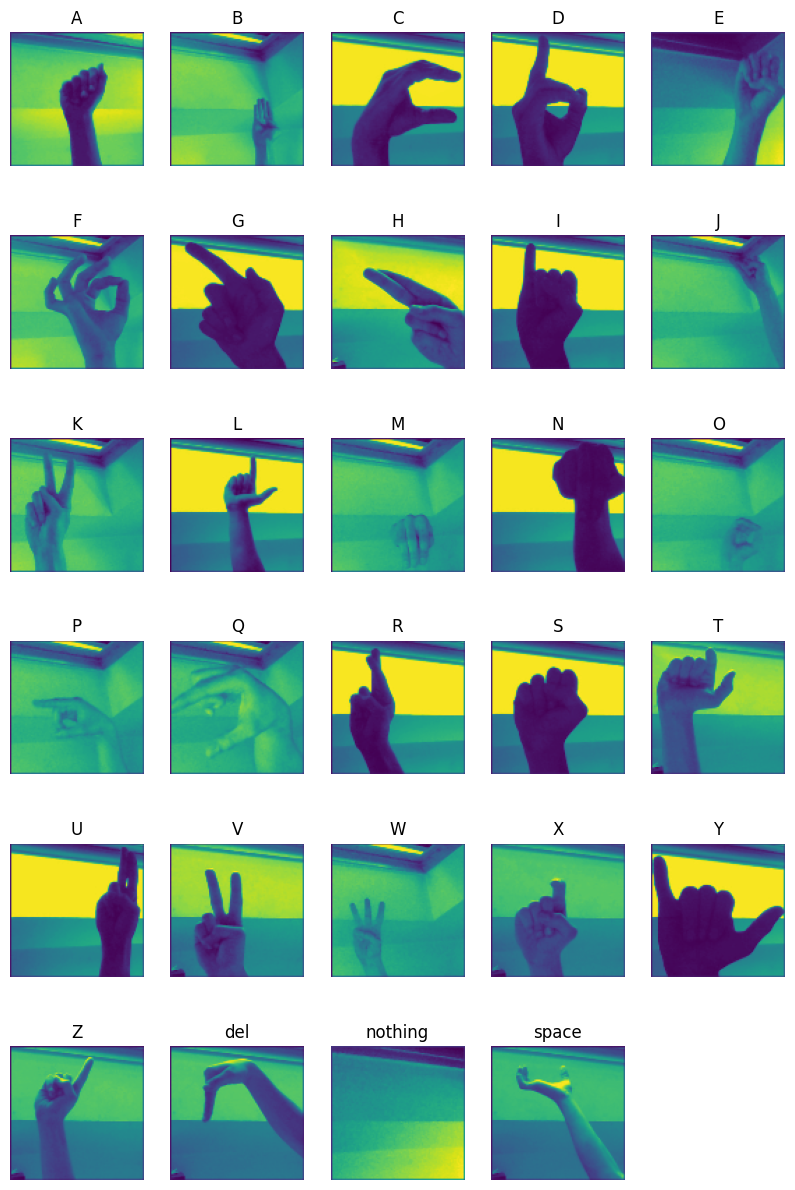

In [9]:
df_train,  df_test = df_init()
df_train['image'] = df_train['filename'].apply(lambda x: readimg(x))
df_test['image'] = df_test['filename'].apply(lambda x: readimg(x))
df_image_visualize(df_train)

## Pemrosesan Citra: _Image Enhancement_

In [24]:
def enhancement_compare_ORB(im, enhancement):
    im_enhanced = enhancement(im)

    orb = cv.ORB_create()
    
    kp = orb.detect(im, None)
    kp_enhanced = orb.detect(im_enhanced, None)

    kp, des = orb.compute(im, kp)
    kp_enhanced, des_enhanced = orb.compute(im_enhanced, kp_enhanced)
    
    im2 = cv.drawKeypoints(im, kp, None, color=(0,255,0), flags=0)
    im2_enhanced = cv.drawKeypoints(im_enhanced, kp_enhanced, None, color=(0,255,0), flags=0)
    
    ax = plt.subplot(2,2,1)
    plt.imshow(im)

    ax = plt.subplot(2,2,2)
    plt.imshow(im_enhanced)

    ax = plt.subplot(2,2,3)
    plt.imshow(im2)

    ax = plt.subplot(2,2,4)
    plt.imshow(im2_enhanced)

    return des, des_enhanced

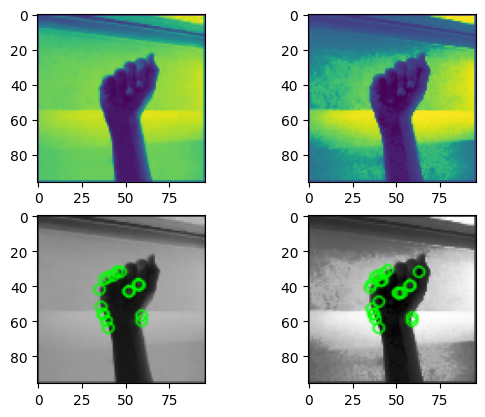

In [25]:
def enhance(img):
    # img = cv.medianBlur(img, 3)
    # img = cv.meanBlur(img, 3)
    # img = cv.medianBlur(img, 3)
    # img = cv.medianBlur(img, 3)
    # img = cv.medianBlur(img, 3)
    img = cv.equalizeHist(img)

    return img

des, des_enhanced = enhancement_compare_ORB(df_train['image'].loc[0], enhance)

In [26]:
print(des.shape)
print(des_enhanced.shape)

(17, 32)
(22, 32)


In [27]:
df_train['image'] = df_train['image'].apply(lambda x: enhance(x))
df_test['image'] = df_test['image'].apply(lambda x: enhance(x))

## Pemrosesan Citra: Ekstraksi Fitur

In [28]:
# Inisiasi ekstraksi fitur ORB (Oriented FAST and Rotated BRIEF)
orb = cv.ORB_create()

# Fungsi untuk mengekstrak fitur ORB dari citra
def extract_ORB_features(im):
    kp = orb.detect(im, None)
    kp, des = orb.compute(im, kp)
    return des

In [57]:
df_train['orb_features'] = df_train['image'].apply(lambda x: extract_ORB_features(x))
df_train['orb_features'] = df_train['orb_features'].apply(lambda x: np.zeros((1,32)) if x is None else x)

df_test['orb_features'] = df_test['image'].apply(lambda x: extract_ORB_features(x))
df_test['orb_features'] = df_test['orb_features'].apply(lambda x: np.zeros((1,32)) if x is None else x)

train_features = np.vstack(df_train['orb_features'].to_numpy())
test_features = np.vstack(df_test['orb_features'].to_numpy())
all_features = np.concatenate([train_features, test_features])

In [58]:
all_features.shape

(1606586, 32)

In [59]:
kmeans = KMeans(n_clusters=150, verbose=1).fit(all_features)

Initialization complete
Iteration 0, inertia 200003952353.0.
Iteration 1, inertia 153728775045.43063.
Iteration 2, inertia 150640991099.3127.
Iteration 3, inertia 149406441619.1488.
Iteration 4, inertia 148704217719.11713.
Iteration 5, inertia 148225418070.9231.
Iteration 6, inertia 147864669825.66656.
Iteration 7, inertia 147578594776.3145.
Iteration 8, inertia 147349955311.48822.
Iteration 9, inertia 147164367559.05374.
Iteration 10, inertia 147012087686.3496.
Iteration 11, inertia 146885531044.6979.
Iteration 12, inertia 146777816983.08493.
Iteration 13, inertia 146685411867.5167.
Iteration 14, inertia 146604736825.6812.
Iteration 15, inertia 146533953753.57556.
Iteration 16, inertia 146471149248.506.
Iteration 17, inertia 146414620610.14478.
Iteration 18, inertia 146363899010.405.
Iteration 19, inertia 146317513357.28214.
Iteration 20, inertia 146275305382.05197.
Iteration 21, inertia 146237157023.479.
Iteration 22, inertia 146203107149.1853.
Iteration 23, inertia 146172320239.3736

In [64]:
kmeans.predict(df_train['orb_features'][116])

array([81], dtype=int32)

In [62]:
np.bincount(kmeans.predict(df_train['orb_features'][116]), minlength=150)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [65]:
df_train['orb_feature_bag'] = df_train['orb_features'].apply(lambda x: np.bincount(kmeans.predict(x), minlength=150))
df_test['orb_feature_bag'] = df_test['orb_features'].apply(lambda x: np.bincount(kmeans.predict(x), minlength=150))

In [66]:
df_train

,filename,class,image,orb_features,orb_feature_bag
0,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,0,"[[32, 32, 25, 30, 30, 30, 30, 30, 30, 30, 30, ...","[[98, 232, 146, 154, 73, 237, 48, 207, 191, 53...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,0,"[[45, 44, 43, 43, 43, 43, 43, 43, 43, 44, 43, ...","[[34, 169, 144, 154, 221, 237, 176, 207, 159, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,0,"[[38, 32, 38, 37, 37, 37, 37, 38, 37, 37, 37, ...","[[0, 77, 18, 156, 81, 205, 180, 103, 188, 132,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,0,"[[35, 35, 33, 35, 35, 33, 28, 33, 33, 35, 33, ...","[[34, 173, 30, 158, 221, 213, 182, 231, 158, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,0,"[[85, 85, 69, 78, 78, 78, 78, 78, 78, 69, 78, ...","[[63, 211, 120, 106, 227, 212, 127, 248, 33, 7...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
57995,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,28,"[[5, 6, 5, 5, 5, 5, 1, 6, 5, 1, 5, 5, 1, 1, 5,...","[[10, 149, 41, 155, 223, 215, 187, 255, 31, 69...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
57996,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,28,"[[6, 5, 5, 5, 1, 1, 5, 5, 5, 5, 5, 6, 5, 5, 5,...","[[252, 172, 188, 126, 141, 125, 87, 207, 243, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
57997,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,28,"[[40, 34, 39, 39, 39, 39, 40, 39, 39, 39, 39, ...","[[79, 175, 132, 154, 253, 181, 188, 239, 223, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
57998,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,28,"[[4, 4, 2, 6, 2, 4, 4, 6, 4, 4, 6, 2, 4, 4, 4,...","[[61, 235, 75, 110, 214, 3, 79, 248, 67, 160, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Klasifikasi dengan SVM

In [67]:
clf = SVC(verbose=True)
clf.fit(np.stack(df_train['orb_feature_bag'].to_numpy()), df_train['class'].to_numpy(dtype=np.int32))

[LibSVM]..*
optimization finished, #iter = 2806
obj = -1138.631665, rho = -0.302917
nSV = 2019, nBSV = 1206
.*.*
optimization finished, #iter = 2027
obj = -838.547322, rho = -0.514881
nSV = 1439, nBSV = 887
.*.*
optimization finished, #iter = 2130
obj = -764.539605, rho = -0.461511
nSV = 1445, nBSV = 790
..*.*
optimization finished, #iter = 3414
obj = -1301.461100, rho = 0.005592
nSV = 2406, nBSV = 1344
.*.*
optimization finished, #iter = 2574
obj = -742.780295, rho = -0.138830
nSV = 1639, nBSV = 729
..*.*
optimization finished, #iter = 3027
obj = -1237.116368, rho = -0.279455
nSV = 2203, nBSV = 1334
..*
optimization finished, #iter = 2782
obj = -938.215988, rho = -0.109654
nSV = 1864, nBSV = 995
..*
optimization finished, #iter = 2990
obj = -1072.236334, rho = -0.112584
nSV = 2029, nBSV = 1097
..*.*
optimization finished, #iter = 3177
obj = -1037.823397, rho = 0.193766
nSV = 2097, nBSV = 1072
.*.*
optimization finished, #iter = 2386
obj = -913.891244, rho = -0.438390
nSV = 1719, nBSV 

SVC(verbose=True)

In [74]:
np.stack(df_test['orb_feature_bag'].to_numpy())

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(14500, 150))

In [76]:
y_pred = clf.predict(np.stack(df_test['orb_feature_bag'].to_numpy()))

In [79]:
y_pred

array([ 0,  0,  0, ..., 15, 26, 21], shape=(14500,), dtype=int32)

In [80]:
df_test['class'].to_numpy(dtype=np.int32)

array([ 0,  0,  0, ..., 28, 28, 28], shape=(14500,), dtype=int32)

In [82]:
print(classification_report(df_test['class'].to_numpy(dtype=np.int32), y_pred))

              precision    recall  f1-score   support

           0       0.57      0.62      0.60       500
           1       0.49      0.63      0.55       500
           2       0.52      0.77      0.62       500
           3       0.75      0.70      0.73       500
           4       0.69      0.62      0.65       500
           5       0.68      0.70      0.69       500
           6       0.55      0.67      0.61       500
           7       0.71      0.69      0.70       500
           8       0.68      0.65      0.66       500
           9       0.71      0.63      0.67       500
          10       0.65      0.68      0.66       500
          11       0.76      0.72      0.74       500
          12       0.69      0.56      0.62       500
          13       0.59      0.54      0.56       500
          14       0.76      0.63      0.69       500
          15       0.72      0.62      0.67       500
          16       0.72      0.61      0.66       500
          17       0.71    

In [83]:
df_train.shape

(58000, 5)

In [84]:
58000 / 29

2000.0